In [5]:
# Francisco Dominguez Mateos
# 27/06/2020
# NOTHING working in here
# Defining a custom layer
#!conda install -c conda-forge opencv --yes
#!conda install -c anaconda tensorflow-gpu --yes
#!conda install -c conda-forge tensorflow-probability --yes
#!conda install -c conda-forge tensorboard --yes

In [1]:
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.nn import relu, log_softmax
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Dense, Relu, LogSoftmax
from jax.experimental.stax import Conv, Flatten, elementwise

import matplotlib.pyplot as plt

In [2]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

In [3]:
#def Reshape(newshape):
#  """Layer construction function for a reshape layer."""
#  init_fun = lambda rng, input_shape: (newshape,())
#  apply_fun = lambda params, inputs, **kwargs: jnp.reshape(inputs,newshape)
#  return init_fun, apply_fun

In [10]:
def Reshape(new_shape):
    def init_func(rng,input_shape):
        ''' there is not weight just change shape'''
        if new_shape[0]==-1:
            rnew_shape=input_shape[0:1]+new_shape[1:]
        else:
            rnew_shape=new_shape
        return (rnew_shape,())
    def apply_func(params,inputs,**kwargs):
        return np.reshape(inputs,new_shape)
    return init_func,apply_func
LogSoftmax2D=elementwise(log_softmax, axis=3)

In [11]:
num_classes=10
init_mlp, mlp = stax.serial(Conv(32, (5, 5), (2, 2), padding="SAME"),
                            #BatchNorm(), #doesn't seem to work with Dense!!!
                            Relu,
                            Flatten,
                            Dense(28*28),
                            Reshape((-1,1,28,28)),
                            LogSoftmax2D)

In [12]:
# Very interesting if we put another dimension 20 in this case
# the model is repeated 20 times and output 20 times num_classes
in_shape = (100, 1,10,10)
output_shape, params = init_mlp(rng, in_shape)
fake_data=random.uniform(rng,in_shape)
print(np.max(fake_data),np.min(fake_data))
print(fake_data.shape)
pred=mlp(params,fake_data)
print("pred=",pred.shape)
print(np.max(pred),np.min(pred))
lsm=log_softmax(pred,axis=0)
print("lsm=",lsm.shape)
print(np.max(lsm),np.min(lsm))

0.99988556 4.2438507e-05
(100, 1, 10, 10)
pred= (100, 1, 28, 28)
-4.4202785 -4.7591043
lsm= (100, 1, 28, 28)
-4.4202785 -4.7591043


-4.4834404 -4.7264633


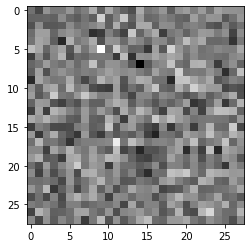

In [13]:
img=np.reshape(pred[0],(28,28))
print(np.max(img),np.min(img))
plt.imshow(img,cmap='gray',)

In [10]:
def Siren(s=[1000]*5,w0=30.0):
    def init_fun(key,input_shape):
        """ Initialize the weights of all layers of a linear layer network """
        sizes=[input_shape[-1]]+s
        print(sizes)
        keys = random.split(key, len(sizes))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, rng):
            scale=np.sqrt(6.0/float(m))
            w_key, b_key = random.split(key)
            return scale * random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        # actually they are pairs plus the random key
        pairs=zip(sizes[:-1], sizes[1:], keys)
        params=[initialize_layer(m, n, k) for m, n, k in pairs]
        # first layer is scalled by w0
        params[0]=params[0][0]*w0,params[0][1]
        output_shape =  input_shape[:-1] + (sizes[-1],)
        return (output_shape,params)
    def apply_fun(params, inputs, **kwargs):
        """ Compute the forward pass for each example individually """
        activations = inputs
        # Loop over the Siren hidden layers
        for w, b in params:
            linear = np.dot(w,activations)+b
            activations=np.sin(linear)
        return activations
    return init_fun, apply_fun      

In [ ]:
def GRU(out_dim, W_init=glorot_normal(), b_init=normal()):
    def init_fun(rng, input_shape):
        """ Initialize the GRU layer for stax """
        hidden = b_init(rng, (input_shape[0], out_dim))

        k1, k2, k3 = random.split(rng, num=3)
        update_W, update_U, update_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        reset_W, reset_U, reset_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        out_W, out_U, out_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)
        # Input dim 0 represents the batch dimension
        # Input dim 1 represents the time dimension (before scan moveaxis)
        output_shape = (input_shape[0], input_shape[1], out_dim)
        return (output_shape,
            (hidden,
             (update_W, update_U, update_b),
             (reset_W, reset_U, reset_b),
             (out_W, out_U, out_b),),)

    def apply_fun(params, inputs, **kwargs):
        """ Loop over the time steps of the input sequence """
        h = params[0]

        def apply_fun_scan(params, hidden, inp):
            """ Perform single step update of the network """
            _, (update_W, update_U, update_b), (reset_W, reset_U, reset_b), (
                out_W, out_U, out_b) = params

            update_gate = sigmoid(np.dot(inp, update_W) +
                                  np.dot(hidden, update_U) + update_b)
            reset_gate = sigmoid(np.dot(inp, reset_W) +
                                 np.dot(hidden, reset_U) + reset_b)
            output_gate = np.tanh(np.dot(inp, out_W)
                                  + np.dot(np.multiply(reset_gate, hidden), out_U)
                                  + out_b)
            output = np.multiply(update_gate, hidden) + np.multiply(1-update_gate, output_gate)
            hidden = output
            return hidden, hidden

        # Move the time dimension to position 0
        inputs = np.moveaxis(inputs, 1, 0)
        f = partial(apply_fun_scan, params)
        _, h_new = lax.scan(f, h, inputs)
        return h_new

    return init_fun, apply_fun